## Import libraries

In [1]:
import pickle
from collections import OrderedDict

import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import balanced_accuracy_score, f1_score, accuracy_score
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real

## Load the dataset

In [2]:

# TODO togliere questo
save_in_test_folder = True
if save_in_test_folder:
    filepath = "../TestModule"
else:
    filepath = "."

seed = 42
FILENAME = "dataset/train_dataset.csv"

# Prepare train data
df1 = pd.read_csv(FILENAME, sep=",", low_memory=False)

# Extract relevant features excluding specified columns
features_to_retain = df1.columns.difference(["label", "ts", "type", "http_referrer"]).tolist()
df1 = df1[features_to_retain + ["type"]]

print("#Righe: " + str(df1.shape[0]) + " #Colonne: " + str(df1.shape[1]))

# Converte i valori in numeri, sostituendo quelli non validi con NaN
df1["src_bytes"] = pd.to_numeric(df1["src_bytes"], errors='coerce')
# Filtra le righe con NaN (valori non convertibili)
df1 = df1.dropna(subset=["src_bytes"])
# Converte i valori rimasti in interi
df1.loc[:, "src_bytes"] = df1["src_bytes"].astype(int)

df1 = df1.dropna()
print("Dopo drop NaN")
print("#Righe: " + str(df1.shape[0]) + " #Colonne: " + str(df1.shape[1]))

features = df1.columns.difference(["type"]).tolist()
X = df1[features]
y = df1["type"]

le = preprocessing.LabelEncoder()
le.fit(y)
with open(f"{filepath}/transformer/target_encoder.save", "wb") as f:
    pickle.dump(le, f)

y = le.transform(y)

indices = np.arange(X.shape[0])
train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=y, random_state=seed)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
fold = np.full(len(y), -1)  # Inizializza tutto con -1 (default: train)

# Assegna i fold ai campioni
for fold_number, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    fold[val_idx] = fold_number  # Assegna il numero del fold ai campioni di validazione

ps = PredefinedSplit(fold)

# Take only X with index in val_idx
X_val = X.iloc[val_idx]
y_val = y[val_idx]

# Take only X with index in train_idx
X_train = X.iloc[train_idx]
y_train = y[train_idx]

#Righe: 617002 #Colonne: 43
Dopo drop NaN
#Righe: 616983 #Colonne: 43


In [3]:
df1

,conn_state,dns_AA,dns_RA,dns_RD,dns_qclass,dns_qtype,dns_query,dns_rcode,dns_rejected,dst_bytes,...,ssl_cipher,ssl_established,ssl_issuer,ssl_resumed,ssl_subject,ssl_version,weird_addl,weird_name,weird_notice,type
0,OTH,-,-,-,0,0,-,0,-,0,...,-,-,-,-,-,-,-,-,-,normal
1,SF,F,F,F,1,43,229.3.in-addr.arpa,0,F,423,...,-,-,-,-,-,-,-,-,-,normal
2,S0,-,-,-,0,0,-,0,-,0,...,-,-,-,-,-,-,-,-,-,normal
3,OTH,-,-,-,0,0,-,0,-,0,...,-,-,-,-,-,-,-,-,-,normal
4,OTH,-,-,-,0,0,-,0,-,0,...,-,-,-,-,-,-,-,-,-,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616997,SF,F,T,T,1,1,detectportal.firefox.com,0,F,424,...,-,-,-,-,-,-,-,-,-,mitm
616998,SF,F,T,T,1,1,detectportal.firefox.com,0,F,436,...,-,-,-,-,-,-,-,-,-,mitm
616999,SF,F,T,T,1,1,s0.2mdn.net,0,F,178,...,-,-,-,-,-,-,-,-,-,mitm
617000,SF,-,-,-,0,0,-,0,-,1212,...,-,-,-,-,-,-,-,-,-,mitm


## Apply K-Nearest Neighbour

In [ ]:
categorical_columns = X_train.select_dtypes(include=["object"]).columns.tolist()
numeric_columns = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

param_grid = {
    'knn__n_neighbors': Integer(3, 15),  # Number of neighbors to consider
    'knn__weights': Categorical(['uniform', 'distance']),  # Weight function
    'knn__metric': Categorical(['euclidean', 'manhattan', 'minkowski']),  # Distance metrics
    'knn__p': Categorical([1, 2]),  # Minkowski parameter (1 for Manhattan, 2 for Euclidean)
    'knn__algorithm': Categorical(['auto', 'ball_tree', 'kd_tree', 'brute']),  # Algorithm to compute neighbors
    'knn__leaf_size': Integer(10, 60),
}

pipeline = Pipeline(
    [
        ('ct', ColumnTransformer(
            [
                ("cat", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_columns),  # Trasforma le colonne categoriche
                ("scale", StandardScaler(), numeric_columns)  # Normalizza le colonne numeriche
            ],
            remainder="passthrough"  # Mantieni le altre colonne invariate
        )),
        ('knn', KNeighborsClassifier())
    ],
    verbose=True
)

grid = BayesSearchCV(pipeline, param_grid, cv=ps, n_iter=50, random_state=seed, verbose=2, scoring="balanced_accuracy")
grid.fit(X, y)

results = pd.DataFrame(grid.cv_results_)
results.to_csv(f"{filepath}/results/knn_results.csv")

print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)
best_knn = grid.best_estimator_.named_steps['knn']

y_pred = best_knn.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_val, y_pred))
print("F1 score:", f1_score(y_val, y_pred, average="weighted"))

### Preprocess the dataset

In [7]:
categorical_columns = X_train.select_dtypes(include=["object"]).columns.tolist()
numeric_columns = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

ct = ColumnTransformer(
    [
        ("cat", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_columns),  # Trasforma le colonne categoriche
        ("scale", StandardScaler(), numeric_columns)  # Normalizza le colonne numeriche
    ],
    remainder="passthrough"  # Mantieni le altre colonne invariate
)
ct.set_output(transform="pandas")

ct = ct.fit(X_train)
with open(f"{filepath}/transformer/transformer_knn.save", "wb") as f:
    pickle.dump(ct, f)

# train set
X_train_knn = ct.transform(X_train)

# validation set
X_val_knn = ct.transform(X_val)

In [8]:
best_params = OrderedDict([('algorithm', 'kd_tree'), ('leaf_size', 52), ('metric', 'manhattan'), ('n_neighbors', 4), ('p', 1), ('weights', 'distance')])

knn = KNeighborsClassifier(**best_params).fit(X_train_knn, y_train)

with open(f"{filepath}/models/knn.save", "wb") as file:
    pickle.dump(knn, file)

y_pred = knn.predict(X_val_knn)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_val, y_pred))
print("F1 score:", f1_score(y_val, y_pred, average="weighted"))

Accuracy: 0.9937599273882459
Balanced accuracy: 0.9792686433162784
F1 score: 0.9937644363620812


## Apply Random Forest

In [ ]:
param_grid = {
    'rf__n_estimators': Integer(50, 400),  # Number of trees in the forest
    'rf__max_depth': Integer(1, 50),  # Maximum depth of the tree
    'rf__min_samples_split': Integer(2, 15),  # Minimum number of samples required to split a node
    'rf__min_samples_leaf': Integer(1, 10),  # Minimum number of samples required at a leaf node
    'rf__max_features': Categorical(['sqrt', 'log2', None]),  # Number of features to consider when looking for the best split
    'rf__bootstrap': Categorical([True, False]),  # Whether bootstrap samples are used when building trees
    'rf__criterion': Categorical(['gini', 'entropy', 'log_loss']),  # Split quality measure
}

pipeline = Pipeline(
    [
        ('ct', ColumnTransformer(
            [
                ("cat", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_columns),  # Trasforma le colonne categoriche
                ("scale", StandardScaler(), numeric_columns)  # Normalizza le colonne numeriche
            ],
            remainder="passthrough"  # Mantieni le altre colonne invariate
        )),
        ('rf', RandomForestClassifier(random_state=seed, class_weight='balanced'))
    ],
    verbose=True
)

grid = BayesSearchCV(pipeline, param_grid, cv=ps, n_iter=50, random_state=seed, verbose=2, scoring="balanced_accuracy")
grid.fit(X, y)

results = pd.DataFrame(grid.cv_results_)
results.to_csv(f"{filepath}/results/rf_results.csv")

print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)
best_rf = grid.best_estimator_.named_steps['rf']
y_pred = best_rf.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_val, y_pred))
print("F1 score:", f1_score(y_val, y_pred, average="weighted"))

In [4]:
categorical_columns = X_train.select_dtypes(include=["object"]).columns.tolist()
numeric_columns = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

ct = ColumnTransformer(
    [
        ("cat", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_columns),  # Trasforma le colonne categoriche
        ("scale", StandardScaler(), numeric_columns)  # Normalizza le colonne numeriche
    ],
    remainder="passthrough"  # Mantieni le altre colonne invariate
)
ct.set_output(transform="pandas")

ct = ct.fit(X_train)
with open(f"{filepath}/transformer/transformer_rf.save", "wb") as f:
    pickle.dump(ct, f)

# train set
X_train_rf = ct.transform(X_train)

# validation set
X_val_rf = ct.transform(X_val)

In [5]:
best_params = OrderedDict([('bootstrap', True), ('criterion', 'gini'), ('max_depth', 40), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 15), ('n_estimators', 50)])

rf = RandomForestClassifier(random_state=seed, class_weight="balanced", **best_params).fit(X_train_rf, y_train)
with open(f"{filepath}/models/rf.save", "wb") as file:
    pickle.dump(rf, file)

y_pred = rf.predict(X_val_rf)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_val, y_pred))
print("F1 score:", f1_score(y_val, y_pred, average="weighted"))

Accuracy: 0.9979740023987812
Balanced accuracy: 0.9973173469248892
F1 score: 0.9979968544579444


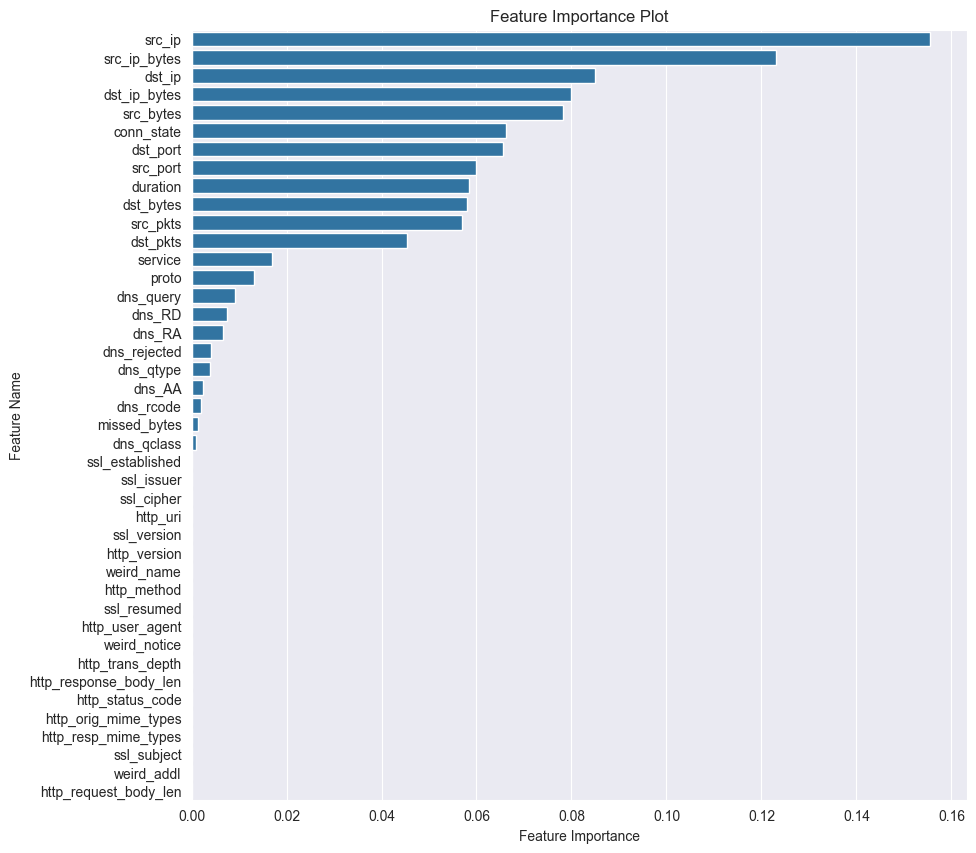

In [6]:
fi = rf.feature_importances_

# plot in order by importance
importances = pd.DataFrame({
    'Feature': [feature.split("__")[1] for feature in rf.feature_names_in_],
    'Importance': fi
}).sort_values('Importance', ascending=False)

# seaborn plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
# plot in order by importance
sns.barplot(x='Importance', y='Feature', data=importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance Plot')
plt.show()

## Apply Support Vector Classifier with HP tuning

In [ ]:
param_grid = {
    'svm__alpha': Real(1e-4, 1),
    'svm__loss': Categorical(["hinge"]),  # "log_loss", "modified_huber", "squared_hinge", "perceptron"
    'svm__penalty': Categorical(["l2", "l1", "elasticnet"]),
    'svm__learning_rate': Categorical(["optimal", "invscaling", "adaptive"]),
    'svm__eta0': Real(1e-2, 10),
    'svm__power_t': Real(1e-1, 5),
    'svm__average': Categorical([True, False]),
    'svm__n_iter_no_change': Integer(5, 20),
    # 'nys__gamma': Real(1e-3, 1),
    # 'nys__n_components': Integer(100, 400)
}

pipeline = Pipeline(
    [
        ('ct', ColumnTransformer(
            [
                ("cat", OneHotEncoder(handle_unknown='infrequent_if_exist', sparse_output=True), categorical_columns),  # Trasforma le colonne categoriche
                ("scale", StandardScaler(), numeric_columns)  # Normalizza le colonne numeriche
            ],
            remainder="passthrough"  # Mantieni le altre colonne invariate
        )),
        # ('nys', Nystroem(random_state=seed)),
        ('svm', SGDClassifier(random_state=seed, class_weight="balanced", verbose=0))
    ],
    verbose=True
)

grid = BayesSearchCV(
    pipeline,
    param_grid,
    n_iter=50,  # Numero massimo di iterazioni
    cv=ps,
    verbose=1,
    random_state=seed,
    scoring="balanced_accuracy"
)
grid.fit(X, y)
results = pd.DataFrame(grid.cv_results_)
results.to_csv(f"{filepath}/results/svm_results.csv")

print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)
best_svm = grid.best_estimator_.named_steps['svm']

y_pred = best_svm.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_val, y_pred))
print("F1 score:", f1_score(y_val, y_pred, average="weighted"))

In [9]:
categorical_columns = X_train.select_dtypes(include=["object"]).columns.tolist()
numeric_columns = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

ct = ColumnTransformer(
    [
        ("cat", OneHotEncoder(handle_unknown='infrequent_if_exist', sparse_output=True), categorical_columns),  # Trasforma le colonne categoriche
        ("scale", StandardScaler(), numeric_columns)  # Normalizza le colonne numeriche
    ],
    remainder="passthrough"  # Mantieni le altre colonne invariate
)
ct = ct.fit(X_train)

with open(f"{filepath}/transformer/transformer_svm.save", "wb") as f:
    pickle.dump(ct, f)

# train set
X_train_svm = ct.transform(X_train)

# validation set
X_val_svm = ct.transform(X_val)

# best_nys_params = OrderedDict([('gamma', 0.22585947457127584), ('n_components', 377)])
#
# nystroem = Nystroem(random_state=seed, **best_nys_params)
# ny = nystroem.fit(X_train)
# with open(f"{filepath}/transformer/nystroem_svm.save", "wb") as f:
#     pickle.dump(ny, f)
#
# X_train_svm = ny.transform(X_train_svm)
# X_val_svm = ny.transform(X_val_svm)

In [10]:
best_params = OrderedDict([('alpha', 0.0001), ('average', False), ('eta0', 0.01), ('learning_rate', 'adaptive'), ('loss', 'hinge'), ('n_iter_no_change', 20), ('penalty', 'l1'), ('power_t', 2.7643426740651593)])

clf = SGDClassifier(random_state=seed, class_weight="balanced", verbose=2, n_jobs=12, **best_params)
clf.fit(X_train_svm, y_train)

with open(f"{filepath}/models/svm.save", "wb") as file:
    pickle.dump(clf, file)

y_pred = clf.predict(X_val_svm)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_val, y_pred))
print("F1 score:", f1_score(y_val, y_pred, average="weighted"))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1-- Epoch 1
-- Epoch 1

-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 18.54, NNZs: 114, Bias: -0.000895, T: 555285, Avg. loss: 0.049409
Total training time: 0.55 seconds.
-- Epoch 2
Norm: 18.54, NNZs: 79, Bias: -0.009971, T: 555285, Avg. loss: 0.062188
Total training time: 0.57 seconds.
-- Epoch 2
Norm: 4.42, NNZs: 32, Bias: -0.007345, T: 555285, Avg. loss: 0.000445
Total training time: 0.60 seconds.
-- Epoch 2
Norm: 9.37, NNZs: 82, Bias: -0.009049, T: 555285, Avg. loss: 0.017521
Total training time: 0.65 seconds.
-- Epoch 2
Norm: 11.94, NNZs: 86, Bias: -0.007539, T: 555285, Avg. loss: 0.054699
Total training time: 0.66 seconds.
-- Epoch 2
Norm: 18.90, NNZs: 62, Bias: -0.010479, T: 555285, Avg. loss: 0.011909
Total training time: 0.66 seconds.
-- Epoch 2
Norm: 37.85, NNZs: 156, Bias: -0.012444, T: 555285, Avg. loss: 0.059329
Total training time: 0.79 seconds.
-- Epoch 2
Norm: 10.59, NNZs: 82, Bias: -0.006659, T: 555285, Avg. loss: 0.029575


[Parallel(n_jobs=12)]: Done   5 out of  10 | elapsed:  1.3min remaining:  1.3min


Norm: 40.98, NNZs: 58, Bias: -0.159420, T: 77184615, Avg. loss: 0.011281
Total training time: 78.74 seconds.
-- Epoch 140
Norm: 46.23, NNZs: 61, Bias: -0.156063, T: 79405755, Avg. loss: 0.039242
Total training time: 78.87 seconds.
Convergence after 143 epochs took 78.87 seconds
Norm: 77.76, NNZs: 49, Bias: -0.191555, T: 73852905, Avg. loss: 0.046755
Total training time: 78.90 seconds.
-- Epoch 134
Norm: 45.95, NNZs: 48, Bias: -0.174672, T: 77184615, Avg. loss: 0.018684
Total training time: 78.94 seconds.
-- Epoch 140
Norm: 73.24, NNZs: 53, Bias: -0.164586, T: 77184615, Avg. loss: 0.055031
Total training time: 79.02 seconds.
-- Epoch 140
Norm: 40.98, NNZs: 58, Bias: -0.159421, T: 77739900, Avg. loss: 0.011281
Total training time: 79.11 seconds.
-- Epoch 141
Norm: 77.76, NNZs: 49, Bias: -0.191555, T: 74408190, Avg. loss: 0.046755
Total training time: 79.24 seconds.
-- Epoch 135
Norm: 45.95, NNZs: 48, Bias: -0.174672, T: 77739900, Avg. loss: 0.018685
Total training time: 79.30 seconds.
--

[Parallel(n_jobs=12)]: Done  10 out of  10 | elapsed:  1.4min finished
